# Binary Classification Dataset

### Importing Libraries and Setting Parameters

In [16]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import random
from PIL import Image

import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

### Listing image files and visualizing

In [15]:
def list_png_files(root_dir):
    png_files = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith('.png'):
                full_path = os.path.join(subdir, file)
                png_files.append(full_path)
    return png_files

train_dir = '/Users/miguelfa/Desktop/Bone-Fracture-Classifier/data/train'
val_dir = '/Users/miguelfa/Desktop/Bone-Fracture-Classifier/data/val'
test_dir = '/Users/miguelfa/Desktop/Bone-Fracture-Classifier/data/test'

train_png_files = list_png_files(train_dir)
val_png_files = list_png_files(val_dir)
test_png_files = list_png_files(test_dir)

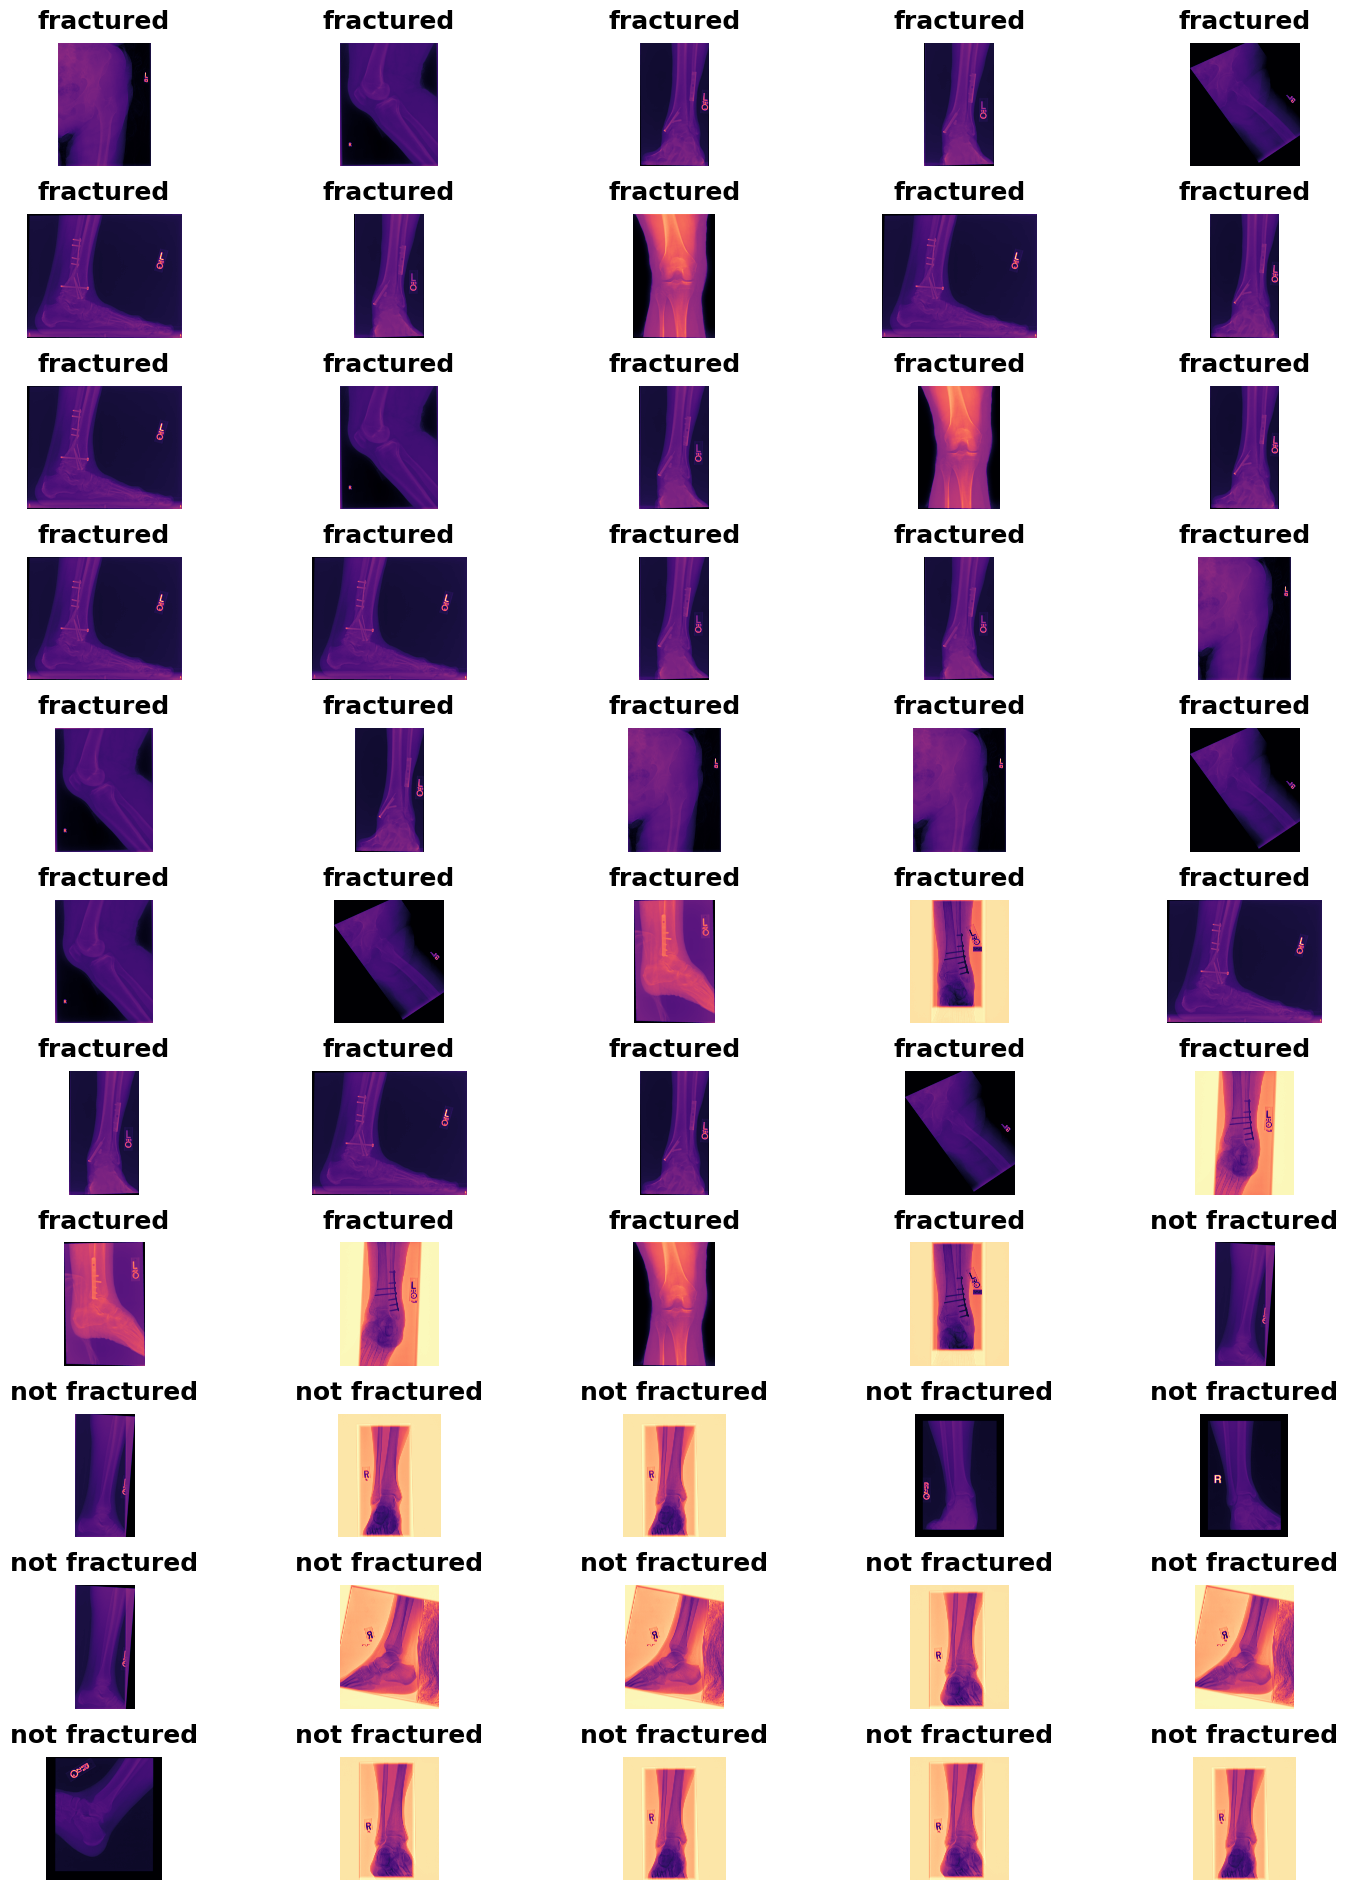

In [19]:
def display_images(list_of_png):
    fig, axes = plt.subplots(nrows=len(list_of_png) // 5, ncols=5, figsize=(15, len(list_of_png) // 3))
    axes = axes.flatten()

    # Display each image
    for img_path, ax in zip(list_of_png, axes):
        image = Image.open(img_path)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(img_path.split('/')[-2])  # Title as the category

    plt.tight_layout()
    plt.show()

display_images(test_png_files)

### Parsing Images and Creating Datasets

In [34]:
# Decodes PNG, resizes Image and normalizes pixels from 0-1.
def parse_image(filename):
    parts = tf.strings.split(filename, os.sep)
    label = tf.cond(tf.strings.regex_full_match(parts[-2], 'fractured'),
                    lambda: 1,
                    lambda: 0)
    image = tf.io.read_file(filename)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = image / 255.0
    return image, tf.cast(label, tf.int32)

# Creates dataset for each element in png list.
train_dataset = tf.data.Dataset.from_tensor_slices(train_png_files)
# Maps each dataset element to parse image function
train_dataset = train_dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# buffered and batched
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(64).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(val_png_files)
val_dataset = val_dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_png_files)
test_dataset = test_dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)

In [23]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Building Model

In [35]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers

image_classifier = keras.Sequential([
    
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

image_classifier.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │     1,476,102 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,495,501 (5.70 MB)

 Trainable params: 1,495,501 (5.70 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# compiling the model
image_classifier.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

### Fitting and model training

In [38]:
history = image_classifier.fit(train_dataset,
                                            validation_data=val_dataset,
                                            epochs=30)

Epoch 1/30


2024-05-04 12:10:13.130626: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:13.458899: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:13.471079: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:10:13.802442: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - binary_accuracy: 0.6548 - loss: 0.4720

2024-05-04 12:10:16.247455: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.6543 - loss: 0.4739 - val_binary_accuracy: 0.7288 - val_loss: 0.4207
Epoch 2/30


2024-05-04 12:10:17.019417: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:17.363101: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:17.373929: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:10:17.684892: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - binary_accuracy: 0.6771 - loss: 0.4409

2024-05-04 12:10:19.840819: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.6736 - loss: 0.4437 - val_binary_accuracy: 0.7966 - val_loss: 0.3500
Epoch 3/30


2024-05-04 12:10:20.613787: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:20.954951: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:20.967356: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:10:21.282606: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - binary_accuracy: 0.7339 - loss: 0.4214

2024-05-04 12:10:23.376965: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.7337 - loss: 0.4237 - val_binary_accuracy: 0.9661 - val_loss: 0.2889
Epoch 4/30


2024-05-04 12:10:24.137648: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:24.476731: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:24.488249: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:10:24.799300: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - binary_accuracy: 0.7472 - loss: 0.4141

2024-05-04 12:10:26.937371: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.7515 - loss: 0.4101 - val_binary_accuracy: 1.0000 - val_loss: 0.2551
Epoch 5/30


2024-05-04 12:10:27.767851: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:28.116173: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:28.126460: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:10:28.440636: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - binary_accuracy: 0.8007 - loss: 0.3215

2024-05-04 12:10:30.374435: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - binary_accuracy: 0.7916 - loss: 0.3267 - val_binary_accuracy: 1.0000 - val_loss: 0.2726
Epoch 6/30


2024-05-04 12:10:31.132107: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:31.479261: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:31.486117: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:10:31.803734: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - binary_accuracy: 0.7773 - loss: 0.3509

2024-05-04 12:10:34.131581: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - binary_accuracy: 0.7760 - loss: 0.3539 - val_binary_accuracy: 1.0000 - val_loss: 0.2633
Epoch 7/30


2024-05-04 12:10:35.100006: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:35.446294: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:35.457510: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:10:35.773218: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - binary_accuracy: 0.7260 - loss: 0.3462

2024-05-04 12:10:37.873268: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.7285 - loss: 0.3436 - val_binary_accuracy: 0.9492 - val_loss: 0.2382
Epoch 8/30


2024-05-04 12:10:38.774430: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:39.125996: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:39.142646: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:10:39.467747: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - binary_accuracy: 0.7339 - loss: 0.3646

2024-05-04 12:10:41.677425: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.7337 - loss: 0.3637 - val_binary_accuracy: 1.0000 - val_loss: 0.1842
Epoch 9/30


2024-05-04 12:10:42.431335: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:42.775990: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:42.786625: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:10:43.095791: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - binary_accuracy: 0.7761 - loss: 0.3099

2024-05-04 12:10:45.079836: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - binary_accuracy: 0.7797 - loss: 0.3056 - val_binary_accuracy: 1.0000 - val_loss: 0.1406
Epoch 10/30


2024-05-04 12:10:45.843558: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:46.193691: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:46.197921: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:10:46.511382: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - binary_accuracy: 0.9065 - loss: 0.2008

2024-05-04 12:10:48.529451: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - binary_accuracy: 0.9065 - loss: 0.1993 - val_binary_accuracy: 1.0000 - val_loss: 0.0869
Epoch 11/30


2024-05-04 12:10:49.333513: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:49.676265: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:49.690433: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:10:50.004255: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - binary_accuracy: 0.8141 - loss: 0.3005

2024-05-04 12:10:52.213234: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.8094 - loss: 0.3047 - val_binary_accuracy: 0.9831 - val_loss: 0.1121
Epoch 12/30


2024-05-04 12:10:52.990872: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:53.338511: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:53.343836: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:10:53.659495: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - binary_accuracy: 0.7973 - loss: 0.1949

2024-05-04 12:10:56.110610: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.8026 - loss: 0.1909 - val_binary_accuracy: 0.9492 - val_loss: 0.1497
Epoch 13/30


2024-05-04 12:10:56.863232: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:57.203948: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:10:57.213206: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:10:57.532893: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - binary_accuracy: 0.8062 - loss: 0.2326

2024-05-04 12:11:00.001043: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.8042 - loss: 0.2327 - val_binary_accuracy: 0.9492 - val_loss: 0.1263
Epoch 14/30


2024-05-04 12:11:00.760980: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:01.106776: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:01.115602: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:11:01.427939: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - binary_accuracy: 0.8274 - loss: 0.1913

2024-05-04 12:11:03.435171: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - binary_accuracy: 0.8272 - loss: 0.1914 - val_binary_accuracy: 1.0000 - val_loss: 0.0528
Epoch 15/30


2024-05-04 12:11:04.200953: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:04.547420: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:04.559564: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:11:04.870574: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - binary_accuracy: 0.8129 - loss: 0.2259

2024-05-04 12:11:07.173997: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.8131 - loss: 0.2250 - val_binary_accuracy: 1.0000 - val_loss: 0.0325
Epoch 16/30


2024-05-04 12:11:07.933618: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:08.281182: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:08.292461: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:11:08.604317: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - binary_accuracy: 0.8485 - loss: 0.2387

2024-05-04 12:11:10.671490: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.8501 - loss: 0.2342 - val_binary_accuracy: 0.9322 - val_loss: 0.1542
Epoch 17/30


2024-05-04 12:11:11.445571: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:11.789391: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:11.799682: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:11:12.112968: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - binary_accuracy: 0.7472 - loss: 0.2470

2024-05-04 12:11:14.323301: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.7515 - loss: 0.2449 - val_binary_accuracy: 0.9322 - val_loss: 0.2181
Epoch 18/30


2024-05-04 12:11:15.128451: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:15.476813: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:15.491409: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:11:15.806850: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - binary_accuracy: 0.7617 - loss: 0.2943

2024-05-04 12:11:17.818775: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.7656 - loss: 0.2927 - val_binary_accuracy: 0.9153 - val_loss: 0.2420
Epoch 19/30


2024-05-04 12:11:18.684822: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:19.064831: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:19.073511: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:11:19.392869: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - binary_accuracy: 0.9131 - loss: 0.2520

2024-05-04 12:11:21.875357: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.9154 - loss: 0.2464 - val_binary_accuracy: 0.9153 - val_loss: 0.2412
Epoch 20/30


2024-05-04 12:11:22.622778: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:22.964110: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:22.973663: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:11:23.295650: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - binary_accuracy: 0.9131 - loss: 0.1902

2024-05-04 12:11:25.202609: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - binary_accuracy: 0.9154 - loss: 0.1888 - val_binary_accuracy: 0.9492 - val_loss: 0.1714
Epoch 21/30


2024-05-04 12:11:26.061030: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:26.405656: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:26.417908: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:11:26.729893: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - binary_accuracy: 0.9276 - loss: 0.1374

2024-05-04 12:11:29.029143: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.9295 - loss: 0.1372 - val_binary_accuracy: 0.9661 - val_loss: 0.1180
Epoch 22/30


2024-05-04 12:11:29.877851: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:30.220978: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:30.232137: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:11:30.554661: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - binary_accuracy: 0.8775 - loss: 0.1780

2024-05-04 12:11:32.434705: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - binary_accuracy: 0.8783 - loss: 0.1799 - val_binary_accuracy: 0.9492 - val_loss: 0.2154
Epoch 23/30


2024-05-04 12:11:33.377017: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:33.723749: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:33.738574: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:11:34.052767: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - binary_accuracy: 0.8842 - loss: 0.2332

2024-05-04 12:11:36.314062: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.8872 - loss: 0.2322 - val_binary_accuracy: 0.9492 - val_loss: 0.2364
Epoch 24/30


2024-05-04 12:11:37.115852: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:37.465983: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:37.475848: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:11:37.789314: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - binary_accuracy: 0.8986 - loss: 0.2521

2024-05-04 12:11:40.289944: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.9013 - loss: 0.2497 - val_binary_accuracy: 0.9492 - val_loss: 0.2308
Epoch 25/30


2024-05-04 12:11:41.291847: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:41.648131: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:41.665362: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:11:41.971430: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - binary_accuracy: 0.9288 - loss: 0.1880

2024-05-04 12:11:44.261300: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.9258 - loss: 0.1899 - val_binary_accuracy: 0.9492 - val_loss: 0.2160
Epoch 26/30


2024-05-04 12:11:45.161127: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:45.503585: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:45.512702: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:11:45.839727: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - binary_accuracy: 0.9131 - loss: 0.2038

2024-05-04 12:11:48.224886: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.9154 - loss: 0.2036 - val_binary_accuracy: 0.9322 - val_loss: 0.1904
Epoch 27/30


2024-05-04 12:11:48.997258: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:49.340940: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:49.350231: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:11:49.672210: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - binary_accuracy: 0.9276 - loss: 0.1799

2024-05-04 12:11:52.146303: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.9295 - loss: 0.1785 - val_binary_accuracy: 0.9492 - val_loss: 0.1539
Epoch 28/30


2024-05-04 12:11:53.029078: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:53.377189: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:53.387877: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:11:53.701569: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - binary_accuracy: 0.9354 - loss: 0.1966

2024-05-04 12:11:56.226988: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.9347 - loss: 0.1987 - val_binary_accuracy: 0.9492 - val_loss: 0.0980
Epoch 29/30


2024-05-04 12:11:57.130418: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:57.493112: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:11:57.507524: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:11:57.818859: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - binary_accuracy: 0.9276 - loss: 0.2283

2024-05-04 12:12:00.303119: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.9295 - loss: 0.2257 - val_binary_accuracy: 1.0000 - val_loss: 0.0278
Epoch 30/30


2024-05-04 12:12:01.129277: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:12:01.469597: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-04 12:12:01.480757: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-05-04 12:12:01.790252: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - binary_accuracy: 0.9644 - loss: 0.1278

2024-05-04 12:12:04.016656: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.9629 - loss: 0.1285 - val_binary_accuracy: 0.9661 - val_loss: 0.0495


### Assessing Accuracy 

<Axes: >

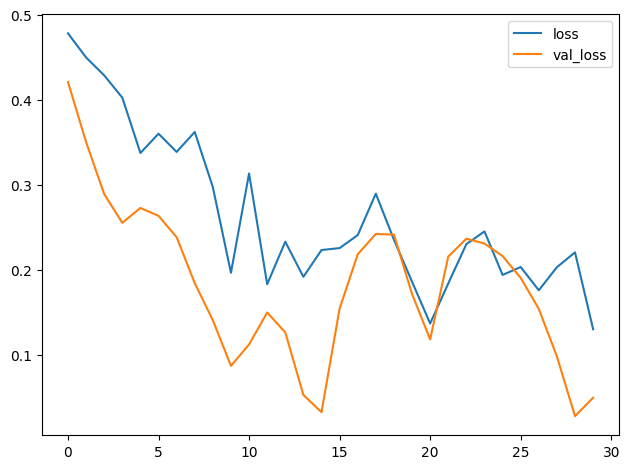

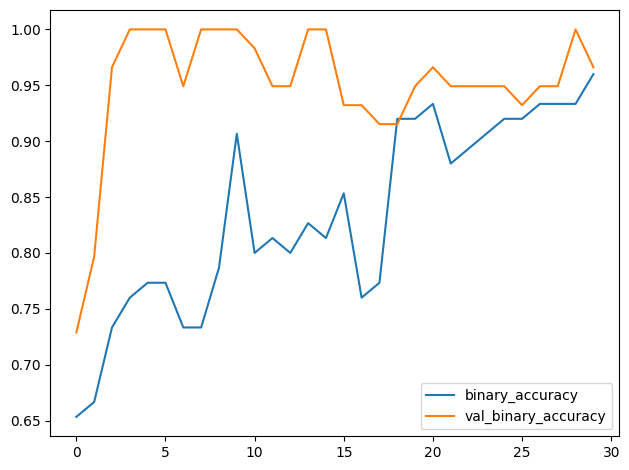

In [40]:
image_classifier_history = pd.DataFrame(history.history)

image_classifier_history.loc[:, ['loss', 'val_loss']].plot()
image_classifier_history.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

### Make Predictions

In [ ]:
_, test_accuracy = image_classifier.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy}")

In [48]:
predictions = image_classifier.predict(test_dataset)
predicted_classes = np.where(predictions > 0.5, 0, 1).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step


In [49]:
predicted_classes

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
def display_predictions(list_png_files, actual, prediction):
    fig, axes = plt.subplots(nrows=len(list_png_files) // 5, ncols=5, figsize=(15, len(list_png_files) // 3))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        ax.imshow(list_png_files[i])
        ax.axis('off')
        
        pred_label = 'Fractured' if predictions[i] == 1 else 'Not Fractured'
        actual_label = 'Fractured' if actual[i] == 1 else 'Not Fractured'
        title = f'Predicted: {pred_label}\nActual: {actual_label}'
        ax.set_title(title, fontsize=10)
    
    plt.tight_layout()
    plt.show()

display_predictions(predicted_classes)